# Worst Case Analysis of Voltage Divider

Three resistors, $R_1$ (10k +/- 5%), $R_2$ (30k +/- 1%), and $R_3$ (10k) are in series from $V_{in}$ (5V +100mV / -50mV) to ground. Determine the worst-case variation of $V_{out}=V_{in}\cdot R_3/(R_1+R_2+R_3)$ by either Monte Carlo or Extreme Value analysis.

Which analysis method to use is generally dependent on two factors:
1. How many variables are there? Extreme Value analysis is performed by brute force; any more than ~10 parameters may take a very long time to compute.
2. Is it likely that the worst case occurs at the extremes of the inputs, or somewhere in the middle? Monte Carlo will be the better choice if maximum resonance is sought, for example.

Functions can of course be nested; a Monte Carlo analysis could be fed into by an Extreme Value analysis, or vice-versa.

In [1]:
from matplotlib import pyplot as plt
from scipy.stats import norm

import worstcase as wca

In [2]:
# A new parameter, created by either a static constructor or
# Extreme Value analysis, will default to using a uniform distribution.
# A distribution function factory may be specified instead, if desired.


def asym_norm(param):
    def dist(n):
        loc = param.nom
        scale = max((param.ub - param.nom), (param.nom - param.lb)) / 3.5
        return norm.rvs(loc=loc, scale=scale, size=n)

    return dist

In [3]:
vin = wca.Param.byrange(
    arg="vin",
    nom=5,
    lb=4.95,
    ub=5.1,
    dist=asym_norm,
    form="{0:.3f} V",
    name="Input Voltage Vin",
)
print(vin)

r1 = wca.Param.bytol(
    arg="r1",
    nom=10e3,
    tol=0.05,
    rel=True,
    form="{0:.2f} kOhm",
    scale=1e-3,
    name="Top Resistor R1",
)
print(r1)

r2 = wca.Param.bytol(
    arg="r2",
    nom=30e3,
    tol=0.01,
    rel=True,
    form="{0:.2f} kOhm",
    scale=1e-3,
    name="Middle Resistor R2",
)
print(r2)

Input Voltage Vin (vin): 4.950 V < 5.000 V < 5.100 V
Top Resistor R1 (r1): 9.50 kOhm < 10.00 kOhm < 10.50 kOhm
Middle Resistor R2 (r2): 29.70 kOhm < 30.00 kOhm < 30.30 kOhm


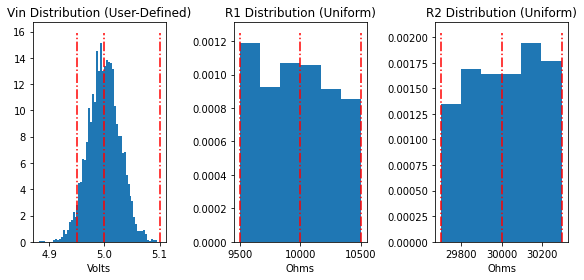

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(8, 4))

vin.plot(n=5000, bins=60, ax=ax[0])
ax[0].set(xlabel="Volts", title="Vin Distribution (User-Defined)")

r1.plot(n=500, bins=6, ax=ax[1])
ax[1].set(xlabel="Ohms", title="R1 Distribution (Uniform)")

r2.plot(n=500, bins=6, ax=ax[2])
ax[2].set(xlabel="Ohms", title="R2 Distribution (Uniform)")

plt.tight_layout()

Output Voltage Vout (vout): 0.972 V < 1.000 V < 1.027 V


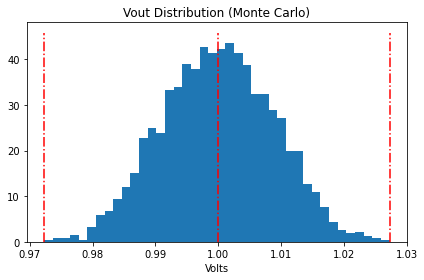

In [5]:
# Compute Vout by Monte Carlo analysis,
# resulting in a sampled distribution.


@wca.mc(
    params=[vin, r1, r2],
    arg="vout",
    n=5000,
    form="{0:.3f} V",
    name="Output Voltage Vout",
)
def voltage_divider_mc(vin, r1, r2, r3):
    return vin * r3 / (r1 + r2 + r3)


vout_mc = voltage_divider_mc(r3=10e3)
print(vout_mc)

vout_mc.plot(n=5000, bins=40)
plt.gca().set(xlabel="Volts", title="Vout Distribution (Monte Carlo)")
plt.tight_layout()

Output Voltage Vout (vout): 0.974 V < 1.000 V < 1.037 V


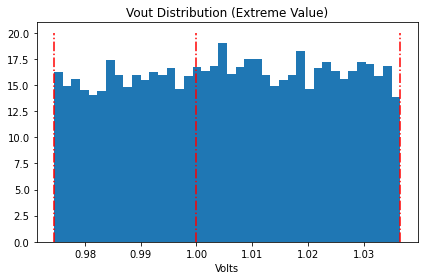

In [6]:
# Compute Vout by Extreme Value analysis,
# resulting in a uniform distribution (by default).


@wca.ev(
    params=[vin, r1, r2],
    arg="vout",
    form="{0:.3f} V",
    name="Output Voltage Vout",
)
def voltage_divider_ev(vin, r1, r2, r3):
    return vin * r3 / (r1 + r2 + r3)


vout_ev = voltage_divider_ev(r3=10e3)
print(vout_ev)

vout_ev.plot(n=5000, bins=40)
plt.gca().set(xlabel="Volts", title="Vout Distribution (Extreme Value)")
plt.tight_layout()

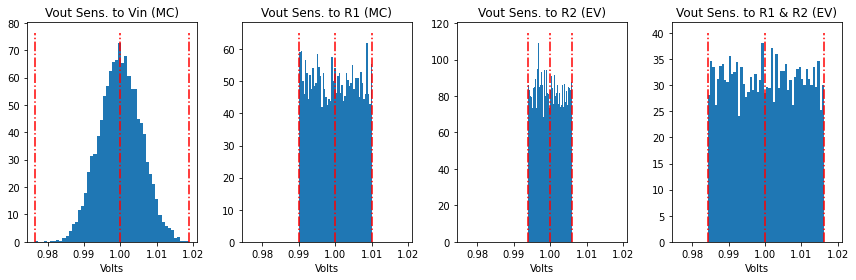

In [7]:
# Input argument ss is reserved for sensitivity studies.
# It may be a single parameter or a list of them.
# Sensitivity studies work with both Monte Carlo and
# Extreme Value analyses; both methods shown below.

vout_ss_vin = voltage_divider_mc(r3=10e3, ss=vin)
vout_ss_r1 = voltage_divider_mc(r3=10e3, ss=r1)
vout_ss_r2 = voltage_divider_ev(r3=10e3, ss=r2)
vout_ss_r1r2 = voltage_divider_ev(r3=10e3, ss=[r1, r2])

fig, ax = plt.subplots(1, 4, sharex=True, figsize=(12, 4))

vout_ss_vin.plot(n=5000, bins=50, ax=ax[0])
ax[0].set(xlabel="Volts", title="Vout Sens. to Vin (MC)")

vout_ss_r1.plot(n=5000, bins=50, ax=ax[1])
ax[1].set(xlabel="Volts", title="Vout Sens. to R1 (MC)")

vout_ss_r2.plot(n=5000, bins=50, ax=ax[2])
ax[2].set(xlabel="Volts", title="Vout Sens. to R2 (EV)")

vout_ss_r1r2.plot(n=5000, bins=50, ax=ax[3])
ax[3].set(xlabel="Volts", title="Vout Sens. to R1 & R2 (EV)")

plt.tight_layout()